In [ ]:
import sys
sys.path.append('../')

In [2]:
import torchxrayvision as xrv
# from torchxrayvision.datasets import COVID19_Dataset
from src.xrayvision import COVID19_Dataset
import torchvision

import torch

from tqdm.auto import tqdm, trange
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import random
import seaborn as sns
%matplotlib inline

In [32]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score, plot_confusion_matrix, plot_roc_curve

In [3]:
from src.visualization import show_images

In [4]:
EXPORT = True

In [5]:
model = xrv.models.DenseNet(weights='all') # CheXpert (Stanford)
model = model.eval()

transform = torchvision.transforms.Compose([xrv.datasets.XRayCenterCrop(),xrv.datasets.XRayResizer(224)])

d_covid19 = COVID19_Dataset(
    '/Users/aniket/Google Drive/Projects/covid-research/data/covid-chestxray-dataset/images',
    '/Users/aniket/Google Drive/Projects/covid-research/data/covid-chestxray-dataset/metadata.csv',
    transform=transform
)

In [6]:
np.isnan(d_covid19[56]['intubated'])

True

In [7]:
d_covid19[random.randint(0, len(d_covid19))]

{'idx': 335,
 'lab': array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 1.], dtype=float32),
 'intubated': nan,
 'img': array([[[-532.6877 , -583.04865, -580.68427, ..., -576.04205,
          -577.40686, -531.8482 ],
         [-763.0932 , -814.43933, -817.7728 , ..., -831.5728 ,
          -832.1598 , -766.07825],
         [-769.4719 , -850.18835, -862.8646 , ..., -831.8141 ,
          -788.3016 , -713.03986],
         ...,
         [ 297.77124,  377.56723,  395.23657, ...,  223.7607 ,
           274.84937,  180.15999],
         [ 329.36517,  415.6304 ,  374.44904, ...,  207.21921,
           212.50743,  244.61526],
         [ 408.73993,  400.93616,  363.7805 , ...,  236.09398,
           207.90071,  281.96735]]], dtype=float32)}

# predict whether intubation required in case of any chest problem
## Create features

In [86]:
images = []
intubation_labels = []
for i in trange(len(d_covid19)):
    sample = d_covid19[i]
    image = sample['img']
    intubated = sample['intubated']
    
    if intubated in ('Y', 'N'):
        images.append(image)
        intubation_labels.append(intubated)
#     if i > 50:
#         break

## generated image embeddings

In [105]:
with torch.no_grad():
    X = []

    avg_pool = torch.nn.AvgPool2d((7, 7))
    for image in tqdm(images):
        image = torch.from_numpy(image)
        image = image.expand(1, 1, 224, 224)
        features = model.features(image)
        #print(features.shape)
        features = avg_pool(features)
        #print(features.shape)
        X.append(features.numpy().reshape(1024))
    X = np.asarray(X)

In [106]:
label_map = {'Y': 1, 'N': 0}
Y = np.asarray([[label_map[e]] for e in intubation_labels])

## Split train test

In [107]:
data = {}
split_pct = 0.75
total = len(X)
idx = list(range(len(X)))
random.shuffle(idx)

train_idx = idx[:int(total*split_pct)]
test_idx = idx[int(total*split_pct):]

data['train'] = X[train_idx], Y[train_idx]
data['test'] = X[test_idx], Y[test_idx]

data['info'] = {
    'train': {   
        'train_count': len(train_idx),
        'train_pos': np.sum(Y[train_idx]==1),
        'train_neg': np.sum(Y[train_idx]==0)   
    },
    'test': {
        'test_count': len(test_idx),
        'test_pos': np.sum(Y[test_idx]==1),
        'test_neg': np.sum(Y[test_idx]==0),   
    }
}

In [108]:
data['info']

{'train': {'train_count': 119, 'train_pos': 65, 'train_neg': 54},
 'test': {'test_count': 40, 'test_pos': 21, 'test_neg': 19}}

## Train models

In [125]:
knn = KNeighborsClassifier(5)
knn.fit(*data['train'])
knn.score(*data['train']), knn.score(*data['test'])

(0.8235294117647058, 0.8)

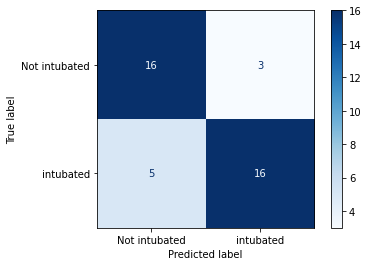

In [130]:
plot_confusion_matrix(
    knn,
    data['test'][0],
    data['test'][1],
    labels=(0, 1),
    display_labels = ('Not intubated', 'intubated'),
    cmap=plt.cm.Blues
)
if EXPORT:
    plt.savefig('../images/intubation_cmat.png')
plt.show()